# Finding the brain area and cortical depth of labeled neurons
In this analysis, we have used Fiji to mark some labeled neurons, and we want to use the Allen CCF to determine what brain area the cells come from, and what their relative depth from the surface of the cortex is. 

This analysis closely follows directions available in the wiki: http://jarahub.uoregon.edu/wiki/Manual_cell_counting_and_registration_to_atlas. It then expands on those instructions to include use of the AllenSDK tool for finding the annotations, as well as a technique for finding the relative depth from pia for each cell. 


In [1]:
# Standard stuff
import os
import numpy as np

# Using jaratoolbox.histologyanalysis for registration and coordinate extraction
from jaratoolbox import histologyanalysis as ha

# We are going to use the allen SDK for getting CCF annotations
# From: https://github.com/AllenInstitute/AllenSDK
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [2]:
# Test animal name
subject = 'anat036'

# The name of the histology slice
sliceName = 'p1d2'

# The coronal Z-index in the Allen CCF corresponding to the histolgy slice
sliceNum = 195

# Register histology slice to CCF

We need to register our histology slice to the CCF in order to determine the transform that we need to apply to coordinates of marked neurons to transform them into the CCF coordinates. This assumes that you have already counted cells and saved the results out, following the instructions here: http://jarahub.uoregon.edu/wiki/Cell_counting_with_Fiji

In [3]:
#Create SVG file for manual registration

#Modify as needed, or change to using jaratoolbox.settings
ATLAS_DIR = '/home/nick/data/atlas'
HISTOLOGY_DIR = '/home/nick/data/histology'
REGISTRATION_DIR = '/home/nick/data/registration'

# Path to the JPG of the atlas slice and the histology slice
filenameAtlas = os.path.join(ATLAS_DIR, 'AllenCCF_25/JPEG/allenCCF_Z{}.jpg'.format(sliceNum))
filenameSlice = os.path.join(HISTOLOGY_DIR, '{}_jpg/5_ac/{}tl.jpg'.format(subject, sliceName))

filenameSVG = os.path.join(REGISTRATION_DIR, '{}/5_ac/{}_pre.svg'.format(subject, sliceName))
(atlasSize, sliceSize) = ha.save_svg_for_registration(filenameSVG, filenameAtlas, filenameSlice)

Saved /home/nick/data/registration/anat036/5_ac/p1d2_pre.svg


In [4]:
filenameSVG = os.path.join(REGISTRATION_DIR, '{}/5_ac/{}.svg'.format(subject, sliceName))
(scale, translate, affine) = ha.get_svg_transform(filenameSVG, sliceSize=[1388, 1040])

filenameCSV = os.path.join(REGISTRATION_DIR, '{}/5_ac/{}.csv'.format(subject, sliceName))
coords = ha.get_coords_from_fiji_csv(filenameCSV, pixelSize=4.0048)

In [5]:
# The coordinates of the cells transformed into the CCF coord space. 
newCoords = ha.apply_svg_transform(scale, translate, affine, coords)

# Finding brain area of each coordinate pair

In [6]:
# We use the 25um voxel size CCF, so this will get you the corresponding annotation volume
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()

# All the CCF stuff starts out as saggital slices, and we reslice to coronal. This does the same with the reference volume
rspAnnotationVolumeRotated = np.rot90(rsp.annotation, 1, axes=(2, 0))

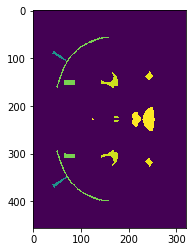

In [34]:
# rspAnnotationVolumeRotated gives the structure ID for each voxel
# The area IDs don't make sense to me, and vary by orders of magnitude, so the image looks strange. 
# but, each voxel contains the ID of the area to which it belongs. 
plt.imshow(rspAnnotationVolumeRotated[:,:,sliceNum])

In [29]:
# X and Y coordinates of the first cell
newCoords[:,0]

array([373.90071982,  85.08236834])

In [30]:
structIDs = []

# For each cell, find its structure ID and append to a list
for indCoords in range(np.shape(newCoords)[1]):
    x = newCoords[0,indCoords]
    y = newCoords[1,indCoords]
    thisCoordID = rspAnnotationVolumeRotated[int(x), int(y), sliceNum]
    structIDs.append(thisCoordID)

In [31]:
# Return a dictionary of information about each structure ID
structDicts = rsp.structure_tree.get_structures_by_id(structIDs)

# Extract just the name of the structure for each cell
structNames = [d['name'] for d in structDicts]

In [32]:
structNames

[u'Anterolateral visual area, layer 6a',
 u'Anterolateral visual area, layer 6a',
 u'Anterolateral visual area, layer 5',
 u'Anterolateral visual area, layer 4',
 u'Anterolateral visual area, layer 4',
 u'Anterolateral visual area, layer 4',
 u'Anterolateral visual area, layer 2/3',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, layer 5',
 u'Posterior auditory area, laye

# Finding cortical depth of each coordinate pair

To find the depth from pia, we are using part of the CCF dataset which is a volume indicating some kind of depth from pia throughout cortex. In practice, using the numbers directly from this volume always produced cortical depth coordinates that did not match well with the distributions of neurons observed in the histology slices. So, we took an approach of simply finding the top and bottom surface of cortex from this volume and calculating the depth of each cell manually. 

In [11]:
# Finding depth from pia
import nrrd
lapPath = os.path.join(ATLAS_DIR, 'AllenCCF_25/coronal_laplacian_25.nrrd')
lapData = nrrd.read(lapPath)
lap = lapData[0]

In [12]:
cortexDepthData = np.rot90(lap[:,:,sliceNum], -1)

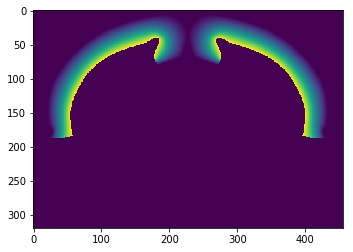

In [13]:
from matplotlib import pyplot as plt
plt.imshow(cortexDepthData)

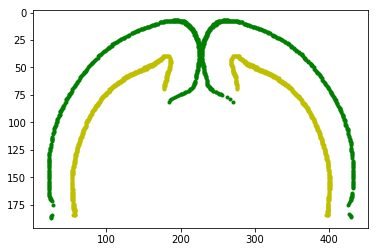

In [17]:
# We consider the points with depth > 0.95 to be the bottom surface of cortex
bottomData = np.where(cortexDepthData>0.95)
plt.plot(bottomData[1], bottomData[0], 'y.')

# Top of cortex is less than 0.02 but greater than 0
topData = np.where((cortexDepthData<0.02) & (cortexDepthData>0))
plt.plot(topData[1], topData[0], 'g.')

# Inverting here since image Y is flipped
plt.gca().invert_yaxis()
plt.show()

In [20]:
# Calculating depth for all coords we got from the CSV file
cellCoords = newCoords 

# Preallocate array to hold the depth of each cell
numCells = np.shape(cellCoords)[1]
cellDepths = np.empty(numCells)

# Iterate through cells
for indCell in range(numCells):
    
    # Get X and Y coords for this cell
    cellX = cellCoords[0, indCell]
    cellY = cellCoords[1, indCell]

    # Distance between the cell and each point on the surface of the brain
    dXTop = topData[1] - cellX
    dYTop = topData[0] - cellY
    distanceTop = np.sqrt(dXTop**2 + dYTop**2)
    
    # The index and distance to the closest point on the top surface
    indMinTop = np.argmin(distanceTop)
    minDistanceTop = distanceTop.min()

    # Same for the distance from the cell to the bottom surface of cortex
    dXBottom = bottomData[1] - cellX
    dYBottom = bottomData[0] - cellY
    distanceBottom = np.sqrt(dXBottom**2 + dYBottom**2)
    minDistanceBottom = distanceBottom.min()

    # The metric we want is the relative distance from the top surface
    cellRatio = minDistanceTop / (minDistanceBottom + minDistanceTop)
    cellDepths[indCell] = cellRatio

In [21]:
cellDepths

array([0.89335259, 0.82387541, 0.61212758, 0.44038189, 0.40931786,
       0.35580303, 0.30912866, 0.57334362, 0.57334362, 0.57334362,
       0.57334362, 0.57334362, 0.57334362, 0.57334362, 0.57334362,
       0.57334362, 0.57334362, 0.57334362, 0.59918649, 0.59918649,
       0.59918649, 0.59918649, 0.59918649, 0.59918649, 0.62412652,
       0.62412652, 0.62412652, 0.62412652, 0.7209823 , 0.59225032])